In [ ]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
import math

# Input basic data

In [ ]:
# Define the number of stations, which is 7 here
num_of_stations = 7
# Define the number of sections, which is 6 here
num_of_sections = 6
# Pure running time of trains with different speeds in each section
pure_running_time = {
    1: [30, 26, 26, 26, 29, 20],  # Speed type 1: 160 km/h
    2: [39, 34, 34, 34, 38, 26]  # Speed type 2: 120 km/h
}
# Define the acceleration and deceleration additional time of a train.
DT = 2  # The acceleration additional time
AT = 3  # The deceleration additional time

# Define the station capacity
station_track_capacity = 5  # The number of tracks per station is limited to 5

# Define M
M = 1080
# Define the minimum maintenance window duration
MOT = 120
# Define the earliest start time for the maintenance window each day
MOT_e = 180  # The earliest start time is 21:00, converted to 180
# Define the lastest end time for the maintenance window each day
MOT_l = 720  # The latest end time is 06:00 (+1), converted to 720

# Define the minimum departure and arrival headway
haa = 6  # The minimum arrival headway is 6 min
hdd = 6  # The minimum departure headway is 6 min
# Define the minimum departure-arrival headway
hda = 2  # The minimum departure-arrival headway is 2 min
# Define the minimum arrival-departure headway between the actual trains and maintenance windows (virtual trains)
had_f = 7  # The minimum arrival-departure headway between the freight trains and maintenance windows is 7 min
had_p = 9  # The minimum arrival-departure headway between the passenger trains and maintenance windows is 9 min

# Define the unscheduling penalty cost for maintenance activities with different importance level
importance_penalty_costs = {
    1: 1000,  # 1 is "normal", the unscheduling penalty cost is set to 1000
    2: 2000,  # 2 is "important", the unscheduling penalty cost is set to 2000
    3: 3000  # 3 is "very important", the unscheduling penalty cost is set to 3000
}

Modify the number of maintenance activities that can be scheduled simultaneously here

In [ ]:
max_compatible_activities = 3  # A maximum of 3 maintenance activities can be scheduled simultaneously in each maintenance window

Modify the maintenance volume and its distribution

In [ ]:
balanced_maintenance_indicator = 1  # 1 means relatively balanced distribution

In [ ]:
maintenance_volume_indicator = 2

In [ ]:
if maintenance_volume_indicator == 1:  # 1 means the maintenance volume of 180, and each section has 30 maintenance activities
    if balanced_maintenance_indicator == 1:  # 1 means relatively balanced distribution
        maintenance_csv = 'balanced_180_maintenance_volume.csv'  # Read the file of 'balanced_180_maintenance_volume.csv'
    else:
        maintenance_csv = 'unbalanced_180_maintenance_volume.csv'  # Read the file of 'unbalanced_180_maintenance_volume.csv'
else:  # 2 means the maintenance volume of 240, and each section has 40 maintenance activities
    if balanced_maintenance_indicator == 1:  # 1 means relatively balanced distribution
        maintenance_csv = 'balanced_240_maintenance_volume.csv'  # Read the file of 'balanced_240_maintenance_volume.csv'
    else:
        maintenance_csv = 'unbalanced_240_maintenance_volume.csv'  # Read the file of 'balanced_240_maintenance_volume.csv'

In [ ]:
maintenance_df = pd.read_csv(maintenance_csv)

# Create a dictionary 'maintenance_activities_info' to store detailed information for each maintenance activity
maintenance_activities_info = {}  # The key is the activity number, and the value is a list containing the activity type, the start day of the optimal scheduling range, the end day of the optimal scheduling range, the fixed scheduling day, the duration, and the importance level.

for _, row in maintenance_df.iterrows():
    maintenance_activities_info[int(row['Activity ID'])] = [
        int(row['Activity Type']),
        int(row['Start Date']),
        int(row['End Date']),
        int(row['Fixed Scheduling Date']),
        int(row['Estimated Duration']),
        int(row['Importance Level'])
    ]

# Create a dictionary 'section_maintenance_activities' to store the activities for each section
section_maintenance_activities = {}

for section in range(1, num_of_sections + 1):
    section_maintenance_activities[section] = list(
        maintenance_df[maintenance_df['Section'] == section]['Activity ID']
    )

Modify the mutually exclusive relationship between maintenance activities here

In [ ]:
maintenance_mutually_exclusive_indicator = 2

In [ ]:
if maintenance_mutually_exclusive_indicator == 1:  # 1 means 29 mutually exclusive maintenance activity pairs
    mutually_exclusive_activities = {
        1: [16, 17, 2],
        3: [4, 8, 16, 17, 2],
        4: [3, 8, 16, 17],
        8: [3, 4, 16, 17],
        11: [16, 17, 14],
        12: [16, 17, 7],
        13: [16, 17, 15],
        15: [16, 17, 10, 13],
        16: [1, 3, 4, 8, 11, 12, 13, 15],
        17: [1, 3, 4, 8, 11, 12, 13, 15],
        2: [1, 3, 14],
        5: [6, 10],
        6: [5],
        7: [12],
        9: [10],
        10: [5, 9, 15],
        14: [2, 11]
    }  # The key is the activity type number, and the value is a list containing the activity type numbers that are mutually exclusive with the activity.
else:  # 2 means 39 mutually exclusive maintenance activity pairs
    mutually_exclusive_activities = {
        1: [16, 17, 2, 5],
        3: [4, 8, 16, 17, 2],
        4: [3, 8, 16, 17],
        8: [3, 4, 16, 17],
        11: [16, 17, 14, 9],
        12: [16, 17, 7, 15],
        13: [16, 17, 10, 15],
        15: [16, 17, 12, 13, 10],
        16: [1, 3, 4, 8, 11, 12, 13, 15],
        17: [1, 3, 4, 8, 11, 12, 13, 15, 14],
        2: [1, 3, 7, 14],
        5: [1, 6, 9, 10],
        6: [5, 7, 10],
        7: [2, 6, 9, 12],
        9: [5, 7, 10, 11],
        10: [5, 6, 9, 13, 15],
        14: [2, 11, 17]
    }

Modify the daily train volumes here

In [ ]:
num_of_trains = [30, 40, 50]  # The number of trains is 30, 40, 50 on day 1, 2, 3

In [ ]:
# Read the train data
# Build a function to read the train data from the 'train_data_XX.csv' file and return a dictionary
def read_train_data(num_trains):
    file_name = f'train_data_{num_trains}.csv'
    df = pd.read_csv(file_name)

    # Create an empty dictionary to store the processed data
    processed_data = {}

    for _, row in df.iterrows():
        departure_range = eval(row['Departure Time Range'])
        stop_scheme = [int(float(x)) for x in eval(row['Stop Scheme'])]

        # Store the processed data into the dictionary 'processed_data'
        processed_data[int(row['Train ID'])] = [
            int(row['Train Type']),
            int(row['Speed Type']),
            departure_range,
            stop_scheme
        ]

    return processed_data


train_info = {}
# Read the train data in the corresponding .csv file according to the daily train volume
for day, num_trains in enumerate(num_of_trains, 1):
    train_info[day] = read_train_data(num_trains)

Generate passenger train timetables

In [ ]:
# The departure time list of passenger trains on each day
passenger_train_departure_times = [30, 90, 150, 210, 615, 645, 675, 705]  # Converted to min
# The dwell time list of passenger trains on each day
passenger_train_dwell_times = [0, 0, 8, 0, 15]  # min
# Create a dictionary to record the arrival and departure time of passenger trains at each station
station_dep_arr_times = {}

for i in range(len(passenger_train_departure_times)):
    arr_times = []  # Store arrival time
    dep_times = []  # Store departure time
    for j in range(num_of_stations):
        # Calculate the arrival and departure time
        if j == 0:  # The train only has the departure time at the start station
            dep_time = passenger_train_departure_times[i]
            dep_times.append(dep_time)
        elif j != num_of_stations - 1:
            if j == 1:
                if passenger_train_dwell_times[j - 1] == 0:
                    arr_time = dep_times[j - 1] + pure_running_time[1][j - 1] + DT
                    dep_time = arr_time
                else:
                    arr_time = dep_times[j - 1] + pure_running_time[1][j - 1] + DT + AT
                    dep_time = arr_time
            else:
                if passenger_train_dwell_times[j - 1] == 0 and passenger_train_dwell_times[
                    j - 2] == 0:
                    arr_time = dep_times[j - 1] + pure_running_time[1][j - 1]
                    dep_time = arr_time
                elif passenger_train_dwell_times[j - 1] != 0 and passenger_train_dwell_times[
                    j - 2] == 0:
                    arr_time = dep_times[j - 1] + pure_running_time[1][j - 1] + AT
                    dep_time = arr_time + passenger_train_dwell_times[j - 1]
                elif passenger_train_dwell_times[j - 1] == 0 and passenger_train_dwell_times[
                    j - 2] != 0:
                    arr_time = dep_times[j - 1] + pure_running_time[1][j - 1] + DT
                    dep_time = arr_time
                else:
                    arr_time = dep_times[j - 1] + pure_running_time[1][j - 1] + DT + AT
                    dep_time = arr_time + passenger_train_dwell_times[j - 1]
            arr_times.append(arr_time)
            dep_times.append(dep_time)
        else:  # The train only has the arrival time at the start station
            if passenger_train_dwell_times[j - 2] == 0:
                arr_time = dep_times[j - 1] + pure_running_time[1][j - 1] + AT
            else:
                arr_time = dep_times[j - 1] + pure_running_time[1][j - 1] + DT + AT
            arr_times.append(arr_time)

        # Fill the dictionary 'station_dep_arr_times', the value of which is a list of departure times and arrival times. The departure time is related to the first station to the second to last station, and the arrival time is related to the second station to the last station.
        station_dep_arr_times[passenger_train_departure_times[i]] = [dep_times, arr_times]

Define the objective function weight combination here

In [ ]:
obj1_weight = 0.5
obj2_weight = 0.5

# Constrct the model

In [ ]:
model = gp.Model('Basic_Model')

## Construct the decision variables

Their meanings are similar to those introduced in the file of 'experiment_with_different_daily_train_volumes_maintenance_volume_mutually_exclusion_max_compatible_num.ipynb'

In [ ]:
dep_time_vars_of_actual_trains = {}
arr_time_vars_of_actual_trains = {}
dwell_time_vars_of_actual_trains = {}
stop_indicator_vars_of_actual_trains = {}

for day, day_train_info in train_info.items():
    dep_time_vars_of_actual_trains[day] = {}
    arr_time_vars_of_actual_trains[day] = {}
    dwell_time_vars_of_actual_trains[day] = {}
    stop_indicator_vars_of_actual_trains[day] = {}

    for train_id, train_data in day_train_info.items():
        train_type = train_data[0]
        speed_type = train_data[1]
        train_departure_range = train_data[2]
        train_stop_plan = train_data[3]

        if train_type == 1:
            train_departure_time = train_departure_range[0]
            for i in range(1, num_of_stations + 1):
                if i == 1:
                    dep_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=station_dep_arr_times[train_departure_time][0][i - 1],
                        ub=station_dep_arr_times[train_departure_time][0][i - 1],
                        vtype=GRB.INTEGER,
                        name=f'dep_time_{day}_{train_id}_station_{i}'
                    )
                elif i != num_of_stations:
                    arr_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=station_dep_arr_times[train_departure_time][1][i - 2],
                        ub=station_dep_arr_times[train_departure_time][1][i - 2],
                        vtype=GRB.INTEGER,
                        name=f'arr_time_{day}_{train_id}_station_{i}'
                    )
                    dep_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=station_dep_arr_times[train_departure_time][0][i - 1],
                        ub=station_dep_arr_times[train_departure_time][0][i - 1],
                        vtype=GRB.INTEGER,
                        name=f'dep_time_{day}_{train_id}_station_{i}'
                    )
                else:
                    arr_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=station_dep_arr_times[train_departure_time][1][i - 2],
                        ub=station_dep_arr_times[train_departure_time][1][i - 2],
                        vtype=GRB.INTEGER,
                        name=f'arr_time_{day}_{train_id}_station_{i}'
                    )
        else:
            for i in range(1, num_of_stations + 1):
                if i == 1:
                    dep_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=train_departure_range[0],
                        ub=train_departure_range[1],
                        vtype=GRB.INTEGER,
                        name=f'dep_time_{day}_{train_id}_station_{i}'
                    )
                elif i != num_of_stations:
                    arr_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=train_departure_range[0],
                        ub=1080,
                        vtype=GRB.INTEGER,
                        name=f'arr_time_{day}_{train_id}_station_{i}'
                    )
                    dep_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=train_departure_range[0],
                        ub=1080,
                        vtype=GRB.INTEGER,
                        name=f'dep_time_{day}_{train_id}_station_{i}'
                    )
                    dwell_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=train_stop_plan[i - 2],
                        ub=60,
                        vtype=GRB.INTEGER,
                        name=f'dwell_time_{day}_{train_id}_station_{i}'
                    )
                    stop_indicator_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        vtype=GRB.BINARY,
                        name=f'stop_indicator_{day}_{train_id}_station_{i}'
                    )
                else:
                    arr_time_vars_of_actual_trains[day][(train_id, i)] = model.addVar(
                        lb=train_departure_range[0],
                        ub=1080,
                        vtype=GRB.INTEGER,
                        name=f'arr_time_{day}_{train_id}_station_{i}'
                    )

In [ ]:
start_time_vars_of_maintenance_windows = {}
end_time_vars_of_maintenance_windows = {}

for day in train_info.keys():
    start_time_vars_of_maintenance_windows[day] = {}
    end_time_vars_of_maintenance_windows[day] = {}
    for i in range(1, num_of_sections + 1):
        start_time_vars_of_maintenance_windows[day][i] = model.addVar(
            lb=MOT_e,
            ub=MOT_l,
            vtype=GRB.INTEGER,
            name=f'maintenance_window_start_time_{day}_section_{i}'
        )
        end_time_vars_of_maintenance_windows[day][i] = model.addVar(
            lb=MOT_e,
            ub=MOT_l,
            vtype=GRB.INTEGER,
            name=f'maintenance_window_end_time_{day}_section_{i}'
        )

In [ ]:
dep_seq_vars_of_actual_trains = {}
arr_seq_vars_of_actual_trains = {}
for day, day_train_info in train_info.items():
    dep_seq_vars_of_actual_trains[day] = {}
    arr_seq_vars_of_actual_trains[day] = {}
    for train_id_1 in day_train_info.keys():
        for train_id_2 in day_train_info.keys():
            if train_id_1 < train_id_2:
                for i in range(1, num_of_sections + 1):
                    dep_seq_vars_of_actual_trains[day][(train_id_1, train_id_2, i)] = model.addVar(
                        vtype=GRB.BINARY,
                        name=f'dep_seq_{day}_{train_id_1}_{train_id_2}_section_{i}'
                    )
                    arr_seq_vars_of_actual_trains[day][(train_id_1, train_id_2, i)] = model.addVar(
                        vtype=GRB.BINARY,
                        name=f'arr_seq_{day}_{train_id_1}_{train_id_2}_section_{i}'
                    )

In [ ]:
maintenance_window_train_seq_vars = {}
for day, day_train_info in train_info.items():
    maintenance_window_train_seq_vars[day] = {}
    for train_id in day_train_info.keys():
        for i in range(1, num_of_sections + 1):
            maintenance_window_train_seq_vars[day][(train_id, i)] = model.addVar(
                vtype=GRB.BINARY,
                name=f'maintenance_window_train_seq_{day}_{train_id}_section_{i}'
            )

In [ ]:
train_meeting_vars = {}
train_arr_dep_seq_vars = {}
for day, day_train_info in train_info.items():
    train_meeting_vars[day] = {}
    train_arr_dep_seq_vars[day] = {}
    for train_id_1 in day_train_info.keys():
        for train_id_2 in day_train_info.keys():
            if train_id_1 < train_id_2:
                for i in range(2, num_of_stations):
                    train_meeting_vars[day][(train_id_1, train_id_2, i)] = model.addVar(
                        vtype=GRB.BINARY,
                        name=f'train_meeting_{day}_{train_id_1}_{train_id_2}_station_{i}'
                    )
                    train_arr_dep_seq_vars[day][(train_id_1, train_id_2, i)] = model.addVar(
                        vtype=GRB.BINARY,
                        name=f'train_arr_dep_seq_{day}_{train_id_1}_{train_id_2}_station_{i}'
                    )
                    train_arr_dep_seq_vars[day][(train_id_2, train_id_1, i)] = model.addVar(
                        vtype=GRB.BINARY,
                        name=f'train_arr_dep_seq_{day}_{train_id_2}_{train_id_1}_station_{i}'
                    )

In [ ]:
maintenance_activity_scheduling_day_vars = {}
for day in train_info.keys():
    for activity_id in maintenance_activities_info.keys():
        maintenance_activity_scheduling_day_vars[(day, activity_id)] = model.addVar(
            vtype=GRB.BINARY,
            name=f'maintenance_activity_scheduling_day_{day}_activity_{activity_id}'
        )

In [ ]:
maintenance_activity_start_time_vars = {}
maintenance_activity_end_time_vars = {}
for day in train_info.keys():
    for activity_id in maintenance_activities_info.keys():
        maintenance_activity_start_time_vars[(day, activity_id)] = model.addVar(
            lb=0,
            ub=720,
            vtype=GRB.INTEGER,
            name=f'maintenance_activity_start_time_{day}_activity_{activity_id}'
        )
        maintenance_activity_end_time_vars[(day, activity_id)] = model.addVar(
            lb=0,
            ub=720,
            vtype=GRB.INTEGER,
            name=f'maintenance_activity_end_time_{day}_activity_{activity_id}'
        )

In [ ]:
maintenance_activity_in_same_day_indicator_vars = {}
for section, maintenance_activities in section_maintenance_activities.items():
    for activity_id_1 in maintenance_activities:
        for activity_id_2 in maintenance_activities:
            if activity_id_1 < activity_id_2:
                start_date_1 = maintenance_activities_info[activity_id_1][1]
                end_date_1 = maintenance_activities_info[activity_id_1][2]
                days_in_range_1 = list(range(start_date_1, end_date_1 + 1))
                start_date_2 = maintenance_activities_info[activity_id_2][1]
                end_date_2 = maintenance_activities_info[activity_id_2][2]
                days_in_range_2 = list(range(start_date_2, end_date_2 + 1))
                common_days = set(days_in_range_1) & set(days_in_range_2)
                for day in common_days:
                    maintenance_activity_in_same_day_indicator_vars[(day, activity_id_1, activity_id_2)] = model.addVar(
                        vtype=GRB.BINARY,
                        name=f'maintenance_activity_in_same_day_{day}_{activity_id_1}_{activity_id_2}'
                    )

In [ ]:
maintenance_activity_seq_vars = {}
for section, maintenance_activities in section_maintenance_activities.items():
    for activity_id_1 in maintenance_activities:
        activity_type_1 = maintenance_activities_info[activity_id_1][0]
        if activity_type_1 in mutually_exclusive_activities:
            for activity_id_2 in maintenance_activities:
                if activity_id_2 == activity_id_1:
                    continue
                activity_type_2 = maintenance_activities_info[activity_id_2][0]
                if activity_type_2 in mutually_exclusive_activities[activity_type_1]:
                    start_date_1 = maintenance_activities_info[activity_id_1][1]
                    end_date_1 = maintenance_activities_info[activity_id_1][2]
                    days_in_range_1 = list(range(start_date_1, end_date_1 + 1))
                    start_date_2 = maintenance_activities_info[activity_id_2][1]
                    end_date_2 = maintenance_activities_info[activity_id_2][2]
                    days_in_range_2 = list(range(start_date_2, end_date_2 + 1))
                    common_days = set(days_in_range_1) & set(days_in_range_2)
                    for day in common_days:
                        if (day, activity_id_1, activity_id_2) in maintenance_activity_seq_vars or (day, activity_id_2,
                                                                                                    activity_id_1) in maintenance_activity_seq_vars:
                            continue
                        maintenance_activity_seq_vars[(day, activity_id_1, activity_id_2)] = model.addVar(
                            vtype=GRB.BINARY,
                            name=f'maintenance_activity_seq_{day}_{activity_id_1}_{activity_id_2}'
                        )

In [ ]:
maintenance_activity_scheduling_simultaneously_indicator_vars = {}
maintenance_activity_start_end_time_seq_vars = {}
for section, maintenance_activities in section_maintenance_activities.items():
    for activity_id_1 in maintenance_activities:
        activity_type_1 = maintenance_activities_info[activity_id_1][0]
        if activity_type_1 in mutually_exclusive_activities:
            for activity_id_2 in maintenance_activities:
                if activity_id_2 == activity_id_1:
                    continue
                activity_type_2 = maintenance_activities_info[activity_id_2][0]
                if activity_type_2 not in mutually_exclusive_activities[activity_type_1]:
                    start_date_1 = maintenance_activities_info[activity_id_1][1]
                    end_date_1 = maintenance_activities_info[activity_id_1][2]
                    days_in_range_1 = list(range(start_date_1, end_date_1 + 1))
                    start_date_2 = maintenance_activities_info[activity_id_2][1]
                    end_date_2 = maintenance_activities_info[activity_id_2][2]
                    days_in_range_2 = list(range(start_date_2, end_date_2 + 1))
                    common_days = set(days_in_range_1) & set(days_in_range_2)
                    for day in common_days:
                        if (day, activity_id_1,
                            activity_id_2) not in maintenance_activity_scheduling_simultaneously_indicator_vars and (
                                day,
                                activity_id_2,
                                activity_id_1) not in maintenance_activity_scheduling_simultaneously_indicator_vars:
                            if activity_id_1 < activity_id_2:
                                maintenance_activity_scheduling_simultaneously_indicator_vars[
                                    (day, activity_id_1, activity_id_2)] = model.addVar(
                                    vtype=GRB.BINARY,
                                    name=f'maintenance_activity_scheduling_simultaneously_{day}_{activity_id_1}_{activity_id_2}'
                                )
                            else:
                                maintenance_activity_scheduling_simultaneously_indicator_vars[
                                    (day, activity_id_2, activity_id_1)] = model.addVar(
                                    vtype=GRB.BINARY,
                                    name=f'maintenance_activity_scheduling_simultaneously_{day}_{activity_id_2}_{activity_id_1}'
                                )
                        if (day, activity_id_1, activity_id_2) not in maintenance_activity_start_end_time_seq_vars and (
                                day, activity_id_2, activity_id_1) not in maintenance_activity_start_end_time_seq_vars:
                            maintenance_activity_start_end_time_seq_vars[
                                (day, activity_id_1, activity_id_2)] = model.addVar(
                                vtype=GRB.BINARY,
                                name=f'maintenance_activity_start_end_time_seq_{day}_{activity_id_1}_{activity_id_2}'
                            )
                            maintenance_activity_start_end_time_seq_vars[
                                (day, activity_id_2, activity_id_1)] = model.addVar(
                                vtype=GRB.BINARY,
                                name=f'maintenance_activity_start_end_time_seq_{day}_{activity_id_2}_{activity_id_1}'
                            )
        else:
            for activity_id_2 in maintenance_activities:
                if activity_id_2 == activity_id_1:
                    continue
                activity_type_2 = maintenance_activities_info[activity_id_2][0]
                if activity_type_2 in mutually_exclusive_activities:
                    if activity_type_1 in mutually_exclusive_activities[activity_type_2]:
                        continue
                start_date_1 = maintenance_activities_info[activity_id_1][1]
                end_date_1 = maintenance_activities_info[activity_id_1][2]
                days_in_range_1 = list(range(start_date_1, end_date_1 + 1))
                start_date_2 = maintenance_activities_info[activity_id_2][1]
                end_date_2 = maintenance_activities_info[activity_id_2][2]
                days_in_range_2 = list(range(start_date_2, end_date_2 + 1))
                common_days = set(days_in_range_1) & set(days_in_range_2)
                for day in common_days:
                    if (day, activity_id_1,
                        activity_id_2) not in maintenance_activity_scheduling_simultaneously_indicator_vars and (day,
                                                                                                                 activity_id_2,
                                                                                                                 activity_id_1) not in maintenance_activity_scheduling_simultaneously_indicator_vars:
                        if activity_id_1 < activity_id_2:
                            maintenance_activity_scheduling_simultaneously_indicator_vars[
                                (day, activity_id_1, activity_id_2)] = model.addVar(
                                vtype=GRB.BINARY,
                                name=f'maintenance_activity_scheduling_simultaneously_{day}_{activity_id_1}_{activity_id_2}'
                            )
                        else:
                            maintenance_activity_scheduling_simultaneously_indicator_vars[
                                (day, activity_id_2, activity_id_1)] = model.addVar(
                                vtype=GRB.BINARY,
                                name=f'maintenance_activity_scheduling_simultaneously_{day}_{activity_id_2}_{activity_id_1}'
                            )
                    if (day, activity_id_1, activity_id_2) not in maintenance_activity_start_end_time_seq_vars and (
                            day, activity_id_2, activity_id_1) not in maintenance_activity_start_end_time_seq_vars:
                        maintenance_activity_start_end_time_seq_vars[
                            (day, activity_id_1, activity_id_2)] = model.addVar(
                            vtype=GRB.BINARY,
                            name=f'maintenance_activity_start_end_time_seq_{day}_{activity_id_1}_{activity_id_2}'
                        )
                        maintenance_activity_start_end_time_seq_vars[
                            (day, activity_id_2, activity_id_1)] = model.addVar(
                            vtype=GRB.BINARY,
                            name=f'maintenance_activity_start_end_time_seq_{day}_{activity_id_2}_{activity_id_1}'
                        )

## Construct the constraints

Their meanings are similar to those introduced in the file of 'experiment_with_different_daily_train_volumes_maintenance_volume_mutually_exclusion_max_compatible_num.ipynb'

In [ ]:
arr_dep_times_cons_of_freight_trains = {}
stop_indicator_cons_of_freight_trains = {}

for day, dwell_time_vars in dwell_time_vars_of_actual_trains.items():
    arr_dep_times_cons_of_freight_trains[day] = {}
    stop_indicator_cons_of_freight_trains[day] = {}
    for (train_id, station_id), dwell_time_var in dwell_time_vars.items():
        arr_time_var = arr_time_vars_of_actual_trains[day][(train_id, station_id)]
        dep_time_var = dep_time_vars_of_actual_trains[day][(train_id, station_id)]
        arr_dep_times_cons_of_freight_trains[day][(train_id, station_id)] = model.addConstr(
            arr_time_var + dwell_time_var == dep_time_var,
            name=f'arr_dep_times_con_{day}_train_{train_id}_station_{station_id}'
        )
        stop_indicator_var = stop_indicator_vars_of_actual_trains[day][(train_id, station_id)]
        stop_indicator_cons_of_freight_trains[day][(train_id, station_id)] = model.addConstr(
            dwell_time_var <= M * stop_indicator_var,
            name=f'stop_indicator_con_{day}_train_{train_id}_station_{station_id}'
        )

In [ ]:
min_section_running_time_cons_of_freight_trains = {}
for day, day_train_info in train_info.items():
    min_section_running_time_cons_of_freight_trains[day] = {}
    for train_id, train_data in day_train_info.items():
        train_type = train_data[0]
        speed_type = train_data[1]
        if train_type == 1:
            continue
        for section_id in range(1, num_of_sections + 1):
            arr_time_var = arr_time_vars_of_actual_trains[day][(train_id, section_id + 1)]
            dep_time_var = dep_time_vars_of_actual_trains[day][(train_id, section_id)]
            pure_run_time = pure_running_time[speed_type][section_id - 1]
            if section_id == 1:
                stop_indicator_var = stop_indicator_vars_of_actual_trains[day][
                    (train_id, section_id + 1)]
                min_section_running_time_cons_of_freight_trains[day][(train_id, section_id)] = model.addConstr(
                    arr_time_var - dep_time_var >= pure_run_time + DT + AT * stop_indicator_var,
                    name=f'min_section_running_time_con_{day}_train_{train_id}_section_{section_id}'
                )
            elif section_id == num_of_sections:
                stop_indicator_var = stop_indicator_vars_of_actual_trains[day][
                    (train_id, section_id)]
                min_section_running_time_cons_of_freight_trains[day][(train_id, section_id)] = model.addConstr(
                    arr_time_var - dep_time_var >= pure_run_time + DT * stop_indicator_var + AT,
                    name=f'min_section_running_time_con_{day}_train_{train_id}_section_{section_id}'
                )
            else:
                stop_indicator_var_1 = stop_indicator_vars_of_actual_trains[day][
                    (train_id, section_id)]
                stop_indicator_var_2 = stop_indicator_vars_of_actual_trains[day][
                    (train_id, section_id + 1)]
                min_section_running_time_cons_of_freight_trains[day][(train_id, section_id)] = model.addConstr(
                    arr_time_var - dep_time_var >= pure_run_time + DT * stop_indicator_var_1 + AT * stop_indicator_var_2,
                    name=f'min_section_running_time_con_{day}_train_{train_id}_section_{section_id}'
                )

In [ ]:
min_maintenance_window_duration_cons = {}
for day in start_time_vars_of_maintenance_windows.keys():
    min_maintenance_window_duration_cons[day] = {}
    for section_id in range(1, num_of_sections + 1):
        start_time_var = start_time_vars_of_maintenance_windows[day][section_id]
        end_time_var = end_time_vars_of_maintenance_windows[day][section_id]
        min_maintenance_window_duration_cons[day][section_id] = model.addConstr(
            end_time_var - start_time_var >= MOT,
            name=f'min_maintenance_window_duration_con_{day}_section_{section_id}'
        )

In [ ]:
dep_time_seq_cons_of_actual_trains = {}
for day, dep_seq_vars in dep_seq_vars_of_actual_trains.items():
    dep_time_seq_cons_of_actual_trains[day] = {}
    for (train_id_1, train_id_2, section_id), dep_seq_var in dep_seq_vars.items():
        dep_time_var_1 = dep_time_vars_of_actual_trains[day][(train_id_1, section_id)]
        dep_time_var_2 = dep_time_vars_of_actual_trains[day][(train_id_2, section_id)]
        dep_time_seq_cons_of_actual_trains[day][(train_id_1, train_id_2, section_id, 1)] = model.addConstr(
            dep_time_var_2 + M * (1 - dep_seq_var) >= dep_time_var_1 + hdd,
            name=f'dep_time_seq_con_day_{day}_train_{train_id_1}_{train_id_2}_section_{section_id}_1'
        )
        dep_time_seq_cons_of_actual_trains[day][(train_id_1, train_id_2, section_id, 2)] = model.addConstr(
            dep_time_var_1 + M * dep_seq_var >= dep_time_var_2 + hdd,
            name=f'dep_time_seq_con_day_{day}_train_{train_id_1}_{train_id_2}_section_{section_id}_2'
        )

In [ ]:
arr_time_seq_cons_of_actual_trains = {}
for day, arr_seq_vars in arr_seq_vars_of_actual_trains.items():
    arr_time_seq_cons_of_actual_trains[day] = {}
    for (train_id_1, train_id_2, section_id), arr_seq_var in arr_seq_vars.items():
        arr_time_var_1 = arr_time_vars_of_actual_trains[day][(train_id_1, section_id + 1)]
        arr_time_var_2 = arr_time_vars_of_actual_trains[day][(train_id_2, section_id + 1)]
        arr_time_seq_cons_of_actual_trains[day][(train_id_1, train_id_2, section_id, 1)] = model.addConstr(
            arr_time_var_2 + M * (1 - arr_seq_var) >= arr_time_var_1 + haa,
            name=f'arr_time_seq_con_day_{day}_train_{train_id_1}_{train_id_2}_section_{section_id}_1'
        )
        arr_time_seq_cons_of_actual_trains[day][(train_id_1, train_id_2, section_id, 2)] = model.addConstr(
            arr_time_var_1 + M * arr_seq_var >= arr_time_var_2 + haa,
            name=f'arr_time_seq_con_day_{day}_train_{train_id_1}_{train_id_2}_section_{section_id}_2'
        )

In [ ]:
consistent_arr_dep_seq_cons_of_actual_trains = {}
for day, arr_seq_vars in arr_seq_vars_of_actual_trains.items():
    consistent_arr_dep_seq_cons_of_actual_trains[day] = {}
    for (train_id_1, train_id_2, section_id), arr_seq_var in arr_seq_vars.items():
        dep_seq_var = dep_seq_vars_of_actual_trains[day][(train_id_1, train_id_2, section_id)]
        consistent_arr_dep_seq_cons_of_actual_trains[day][(train_id_1, train_id_2, section_id)] = model.addConstr(
            arr_seq_var == dep_seq_var,
            name=f'consistent_arr_dep_seq_con_day_{day}_train_{train_id_1}_{train_id_2}_section_{section_id}_1'
        )

In [ ]:
maintenance_window_train_seq_cons = {}
for day in maintenance_window_train_seq_vars.keys():
    day_train_info = train_info[day]
    maintenance_window_train_seq_cons[day] = {}
    for (train_id, section_id), seq_var in maintenance_window_train_seq_vars[day].items():
        train_type = day_train_info[train_id][0]
        dep_time_var = dep_time_vars_of_actual_trains[day][(train_id, section_id)]
        arr_time_var = arr_time_vars_of_actual_trains[day][(train_id, section_id + 1)]
        start_time_var = start_time_vars_of_maintenance_windows[day][section_id]
        end_time_var = end_time_vars_of_maintenance_windows[day][section_id]
        if train_type == 1:
            maintenance_window_train_seq_cons[day][(train_id, section_id, 1)] = model.addConstr(
                dep_time_var + M * (1 - seq_var) >= end_time_var + had_p,
                name=f'maintenance_window_train_seq_con_day_{day}_train_{train_id}_section_{section_id}_1'
            )
            maintenance_window_train_seq_cons[day][(train_id, section_id, 2)] = model.addConstr(
                start_time_var + M * seq_var >= arr_time_var + had_p,
                name=f'maintenance_window_train_seq_con_day_{day}_train_{train_id}_section_{section_id}_2'
            )
        else:
            maintenance_window_train_seq_cons[day][(train_id, section_id, 1)] = model.addConstr(
                dep_time_var + M * (1 - seq_var) >= end_time_var + had_f,
                name=f'maintenance_window_train_seq_con_day_{day}_train_{train_id}_section_{section_id}_1'
            )
            maintenance_window_train_seq_cons[day][(train_id, section_id, 2)] = model.addConstr(
                start_time_var + M * seq_var >= arr_time_var + had_f,
                name=f'maintenance_window_train_seq_con_day_{day}_train_{train_id}_section_{section_id}_2'
            )

In [ ]:
maintenance_activities_day_scheduling_time_cons = {}  # The constraints for the scheduling time of maintenance activities on a specific day, which are the constraints (21) and (22)
maintenance_activities_day_scheduling_range_cons = {}
maintenance_activities_day_duration_cons = {}

for day in train_info.keys():
    for section, maintenance_activities in section_maintenance_activities.items():
        for activity_id in maintenance_activities:
            maintenance_activity_duration = maintenance_activities_info[activity_id][4]
            start_time_var = maintenance_activity_start_time_vars[(day, activity_id)]
            end_time_var = maintenance_activity_end_time_vars[(day, activity_id)]
            x_var = maintenance_activity_scheduling_day_vars[(day, activity_id)]
            start_window_time = start_time_vars_of_maintenance_windows[day][section]
            end_window_time = end_time_vars_of_maintenance_windows[day][section]
            # If the maintenance activity is scheduled on that day, the start time must be greater than or equal to the start time of the maintenance window.
            maintenance_activities_day_scheduling_time_cons[(day, section, activity_id, 1)] = model.addConstr(
                start_window_time + M * (x_var - 1) <= start_time_var,
                name=f'maintenance_activity_start_time_con_day_{day}_section_{section}_activity_{activity_id}'
            )
            # If the maintenance activity is scheduled on that day, the end time must be less than or equal to the end time of the maintenance window.
            maintenance_activities_day_scheduling_time_cons[(day, section, activity_id, 2)] = model.addConstr(
                M * (x_var - 1) + end_time_var <= end_window_time,
                name=f'maintenance_activity_end_time_con_day_{day}_section_{section}_activity_{activity_id}'
            )
            maintenance_activities_day_scheduling_range_cons[(day, activity_id, 1, 1)] = model.addConstr(
                start_time_var <= MOT_l * x_var,
                name=f'maintenance_activity_start_range_con_day_{day}_activity_{activity_id}_1'
            )
            maintenance_activities_day_scheduling_range_cons[(day, activity_id, 1, 2)] = model.addConstr(
                start_time_var >= MOT_e * x_var,
                name=f'maintenance_activity_start_range_con_day_{day}_activity_{activity_id}_2'
            )
            maintenance_activities_day_scheduling_range_cons[(day, activity_id, 2, 1)] = model.addConstr(
                end_time_var <= MOT_l * x_var,
                name=f'maintenance_activity_end_range_con_day_{day}_activity_{activity_id}_1'
            )
            maintenance_activities_day_scheduling_range_cons[(day, activity_id, 2, 2)] = model.addConstr(
                end_time_var >= MOT_e * x_var,
                name=f'maintenance_activity_end_range_con_day_{day}_activity_{activity_id}_2'
            )
            maintenance_activities_day_duration_cons[(day, activity_id)] = model.addConstr(
                end_time_var - start_time_var >= maintenance_activity_duration * x_var,
                name=f'maintenance_activity_duration_con_day_{day}_activity_{activity_id}'
            )

In [ ]:
maintenance_activity_in_same_day_cons = {}
for (day, activity_id_1, activity_id_2), var in maintenance_activity_in_same_day_indicator_vars.items():
    x_var_1 = maintenance_activity_scheduling_day_vars[(day, activity_id_1)]
    x_var_2 = maintenance_activity_scheduling_day_vars[(day, activity_id_2)]
    maintenance_activity_in_same_day_cons[(day, activity_id_1, activity_id_2, 1)] = model.addConstr(
        var <= x_var_1,
        name=f'maintenance_activity_in_same_day_con_day_{day}_activity_{activity_id_1}_{activity_id_2}_1'
    )
    maintenance_activity_in_same_day_cons[(day, activity_id_1, activity_id_2, 2)] = model.addConstr(
        var <= x_var_2,
        name=f'maintenance_activity_in_same_day_con_day_{day}_activity_{activity_id_1}_{activity_id_2}_2'
    )
    maintenance_activity_in_same_day_cons[(day, activity_id_1, activity_id_2, 3)] = model.addConstr(
        var >= x_var_1 + x_var_2 - 1,
        name=f'maintenance_activity_in_same_day_con_day_{day}_activity_{activity_id_1}_{activity_id_2}_3'
    )

In [ ]:
maintenance_activity_seq_cons = {}
for (day, activity_id_1, activity_id_2), var in maintenance_activity_seq_vars.items():
    start_time_var_1 = maintenance_activity_start_time_vars[(day, activity_id_1)]
    start_time_var_2 = maintenance_activity_start_time_vars[(day, activity_id_2)]
    end_time_var_1 = maintenance_activity_end_time_vars[(day, activity_id_1)]
    end_time_var_2 = maintenance_activity_end_time_vars[(day, activity_id_2)]
    maintenance_activity_seq_cons[(day, activity_id_1, activity_id_2, 1)] = model.addConstr(
        start_time_var_2 + M * (1 - var) >= end_time_var_1,
        name=f'maintenance_activity_seq_con_day_{day}_activity_{activity_id_1}_{activity_id_2}_1'
    )
    maintenance_activity_seq_cons[(day, activity_id_1, activity_id_2, 2)] = model.addConstr(
        start_time_var_1 + M * var >= end_time_var_2,
        name=f'maintenance_activity_seq_con_day_{day}_activity_{activity_id_1}_{activity_id_2}_2'
    )

In [ ]:
major_maintenance_activity_must_be_scheduled_cons = {}
for maintenance_activity in maintenance_activities_info:
    activity_type = maintenance_activities_info[maintenance_activity][0]
    if activity_type == 3 or activity_type == 4 or activity_type == 8:
        start_date = maintenance_activities_info[maintenance_activity][1]
        end_date = maintenance_activities_info[maintenance_activity][2]
        for day in range(start_date, end_date + 1):
            major_maintenance_activity_must_be_scheduled_cons[(day, maintenance_activity)] = model.addConstr(
                maintenance_activity_scheduling_day_vars[(day, maintenance_activity)] == 1,
                name=f'major_maintenance_activity_must_be_scheduled_con_day_{day}_activity_{maintenance_activity}'
            )

In [ ]:
routine_maintenance_activity_most_once_scheduled_cons = {}
for maintenance_activity in maintenance_activities_info:
    activity_type = maintenance_activities_info[maintenance_activity][0]
    if activity_type != 3 and activity_type != 4 and activity_type != 8:
        start_date = maintenance_activities_info[maintenance_activity][1]
        end_date = maintenance_activities_info[maintenance_activity][2]
        temp_str = gp.LinExpr(0)
        for day in [1, 2, 3]:
            temp_str += maintenance_activity_scheduling_day_vars[(day, maintenance_activity)]
        routine_maintenance_activity_most_once_scheduled_cons[maintenance_activity] = model.addConstr(
            temp_str <= 1,
            name=f'routine_maintenance_activity_most_once_scheduled_con_activity_{maintenance_activity}'
        )

## Construct the objective function

In [ ]:
# Objective function 1
obj1 = gp.LinExpr(0)
for day, day_train_info in train_info.items():
    for train_id, train_data in day_train_info.items():
        train_type = train_data[0]
        if train_type == 1:
            continue
        arr_time_var = arr_time_vars_of_actual_trains[day][(train_id, num_of_stations)]
        dep_time_var = dep_time_vars_of_actual_trains[day][(train_id, 1)]
        obj1 += arr_time_var - dep_time_var

In [ ]:
# Objective function 2
obj2 = gp.LinExpr(0)
for activity_id, activity_info in maintenance_activities_info.items():
    activity_type = activity_info[0]
    if activity_type == 3 or activity_type == 4 or activity_type == 8:
        continue
    start_date = activity_info[1]
    end_date = activity_info[2]
    importance_level = activity_info[5]
    temp_str = gp.LinExpr(0)
    for day in range(start_date, end_date + 1):
        temp_str += maintenance_activity_scheduling_day_vars[(day, activity_id)]
    obj2 += importance_penalty_costs[importance_level] * (1 - temp_str)

In [ ]:
# Take the weighted sum of obj1 and obj2 to construct the objective function
model.setObjective(obj1_weight * obj1 + obj2_weight * obj2, GRB.MINIMIZE)

## callback functions

The callback functions are used to append constraints that have not been considered. For train timetabling with maintenance window setting, it is necessary to handle station capacity-related constraints. For maintenance activities, it is necessary to handle the constraints related to the limited number of compatible maintenance activities scheduled simultaneously. The logic of these functions is similar to that in the file of 'experiment_with_different_daily_train_volumes_maintenance_volume_mutually_exclusion_max_compatible_num.ipynb'.
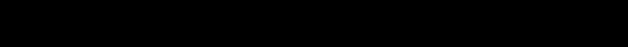

In [ ]:
# Define the constraint pools to avoid adding lazy constraints repeatedly
# Station capacity-related constraint pool
station_capacity_limitation_cons = {}
for day in train_info.keys():
    station_capacity_limitation_cons[day] = {}
    for station_id in range(2, num_of_stations):
        station_capacity_limitation_cons[day][station_id] = {}
# The constraint pool for the limited number of compatible maintenance activities scheduled simultaneously
maintenance_activity_simultaneous_number_limitation_cons = {}
for day in train_info.keys():
    maintenance_activity_simultaneous_number_limitation_cons[day] = {}
    for section_id in range(1, num_of_sections + 1):
        maintenance_activity_simultaneous_number_limitation_cons[day][section_id] = {}
# Define the constraint violation counters
lazy_cons_count = 0
station_capacity_limitation_lazy_cons_count = 0
maintenance_activity_simultaneous_number_lazy_cons_count = 0

In [ ]:
def lazy_callback(model, where):
    if where == GRB.Callback.MIPSOL:
        temp_obj = model.cbGet(GRB.Callback.MIPSOL_OBJ)
        upper_bound = model.cbGet(GRB.Callback.MIPSOL_OBJBST)
        lower_bound = model.cbGet(GRB.Callback.MIPSOL_OBJBND)

        dep_time_vars_of_actual_trains_sol = {}
        for inner_day in train_info.keys():
            dep_time_vars_of_actual_trains_sol[inner_day] = {}
            for inner_key, inner_dep_time_var in model._dep_time_vars_of_actual_trains[inner_day].items():
                dep_time_vars_of_actual_trains_sol[inner_day][inner_key] = model.cbGetSolution(inner_dep_time_var)
        arr_time_vars_of_actual_trains_sol = {}
        for inner_day in train_info.keys():
            arr_time_vars_of_actual_trains_sol[inner_day] = {}
            for inner_key, inner_arr_time_var in model._arr_time_vars_of_actual_trains[inner_day].items():
                arr_time_vars_of_actual_trains_sol[inner_day][inner_key] = model.cbGetSolution(inner_arr_time_var)
        maintenance_activity_start_time_vars_sol = {name: model.cbGetSolution(time_var) for name, time_var in
                                                    model._maintenance_activity_start_time_vars.items()}
        maintenance_activity_end_time_vars_sol = {name: model.cbGetSolution(time_var) for name, time_var in
                                                  model._maintenance_activity_end_time_vars.items()}

        violated_station_track_capacity_con_trains = {}
        for d, d_train_info in train_info.items():
            violated_station_track_capacity_con_trains[d] = {}
            for inner_station_id in range(2, num_of_stations):
                violated_station_track_capacity_con_trains[d][inner_station_id] = []
                train_id_list = sorted(d_train_info.keys())
                for inner_train_id_1 in train_id_list:
                    train_count_at_station = 0
                    inner_arr_time_1 = arr_time_vars_of_actual_trains_sol[d][(inner_train_id_1, inner_station_id)]
                    inner_dep_time_1 = dep_time_vars_of_actual_trains_sol[d][(inner_train_id_1, inner_station_id)]
                    if abs(inner_dep_time_1 - inner_arr_time_1) < 1e-6:
                        continue
                    else:
                        train_count_at_station += 1
                        meeting_trains = [inner_train_id_1]
                        for inner_train_id_2 in train_id_list:
                            if inner_train_id_2 > inner_train_id_1:
                                inner_arr_time_2 = arr_time_vars_of_actual_trains_sol[d][
                                    (inner_train_id_2, inner_station_id)]
                                inner_dep_time_2 = dep_time_vars_of_actual_trains_sol[d][
                                    (inner_train_id_2, inner_station_id)]
                                if abs(inner_dep_time_2 - inner_arr_time_2) < 1e-6: continue
                                if inner_dep_time_2 > inner_arr_time_1 and inner_arr_time_2 < inner_dep_time_1:
                                    train_count_at_station += 1
                                    meeting_trains.append(inner_train_id_2)
                        if train_count_at_station > station_track_capacity or len(
                                meeting_trains) > station_track_capacity:
                            violated_station_track_capacity_con_trains[d][inner_station_id].append(
                                sorted(meeting_trains))

        violated_maintenance_activity_simultaneous_number_con_maintenance_activities = {}
        for d in train_info.keys():
            violated_maintenance_activity_simultaneous_number_con_maintenance_activities[d] = {}
            for inner_section_id, inner_maintenance_activities in section_maintenance_activities.items():
                violated_maintenance_activity_simultaneous_number_con_maintenance_activities[d][
                    inner_section_id] = []
                for inner_activity_id_1 in inner_maintenance_activities:
                    simultaneous_count = 0
                    maintenance_activity_start_time_1 = maintenance_activity_start_time_vars_sol[
                        (d, inner_activity_id_1)]
                    maintenance_activity_end_time_1 = maintenance_activity_end_time_vars_sol[(d, inner_activity_id_1)]
                    if abs(maintenance_activity_end_time_1 - maintenance_activity_start_time_1) < 1e-6:
                        continue
                    else:
                        simultaneous_count += 1
                        meeting_activities = [inner_activity_id_1]
                        for inner_activity_id_2 in inner_maintenance_activities:
                            if inner_activity_id_2 > inner_activity_id_1:
                                maintenance_activity_start_time_2 = maintenance_activity_start_time_vars_sol[
                                    (d, inner_activity_id_2)]
                                maintenance_activity_end_time_2 = maintenance_activity_end_time_vars_sol[
                                    (d, inner_activity_id_2)]
                                if maintenance_activity_end_time_2 > maintenance_activity_start_time_1 and maintenance_activity_end_time_1 > maintenance_activity_start_time_2:
                                    simultaneous_count += 1
                                    meeting_activities.append(inner_activity_id_2)
                        if simultaneous_count > max_compatible_activities or len(
                                meeting_activities) > max_compatible_activities:
                            violated_maintenance_activity_simultaneous_number_con_maintenance_activities[d][
                                inner_section_id].append(sorted(
                                meeting_activities))

        global lazy_cons_count
        global station_capacity_limitation_lazy_cons_count
        global maintenance_activity_simultaneous_number_lazy_cons_count
        global station_capacity_limitation_cons
        global maintenance_activity_simultaneous_number_limitation_cons

        # For constraints (17)-(20)
        for d, d_station_train_lists in violated_station_track_capacity_con_trains.items():
            for inner_station_id, inner_train_lists in d_station_train_lists.items():
                for train_ids in inner_train_lists:
                    for train_combination in combinations(train_ids, station_track_capacity + 1):
                        train_combination = sorted(train_combination)
                        for inner_train_id_1 in train_combination:
                            for inner_train_id_2 in train_combination:
                                if inner_train_id_2 > inner_train_id_1:
                                    if (inner_train_id_1, inner_train_id_2, 1) in station_capacity_limitation_cons[d][
                                        inner_station_id] or (inner_train_id_1, inner_train_id_2, 2) in \
                                            station_capacity_limitation_cons[d][inner_station_id] or (inner_train_id_1,
                                                                                                      inner_train_id_2,
                                                                                                      3) in \
                                            station_capacity_limitation_cons[d][inner_station_id] or (inner_train_id_1,
                                                                                                      inner_train_id_2,
                                                                                                      4) in \
                                            station_capacity_limitation_cons[d][inner_station_id] or (inner_train_id_1,
                                                                                                      inner_train_id_2,
                                                                                                      5) in \
                                            station_capacity_limitation_cons[d][inner_station_id]:
                                        continue
                                    station_capacity_limitation_cons[d][inner_station_id][
                                        (inner_train_id_1, inner_train_id_2, 1)] = model.cbLazy(
                                        M * (model._train_arr_dep_seq_vars[d][
                                                 (inner_train_id_1, inner_train_id_2, inner_station_id)] - 1) <=
                                        model._dep_time_vars_of_actual_trains[d][(inner_train_id_2, inner_station_id)] -
                                        model._arr_time_vars_of_actual_trains[d][(inner_train_id_1, inner_station_id)]
                                    )
                                    station_capacity_limitation_cons[d][inner_station_id][
                                        (inner_train_id_1, inner_train_id_2, 2)] = model.cbLazy(
                                        model._dep_time_vars_of_actual_trains[d][(inner_train_id_2, inner_station_id)] -
                                        model._arr_time_vars_of_actual_trains[d][
                                            (inner_train_id_1, inner_station_id)] <= M *
                                        model._train_arr_dep_seq_vars[d][
                                            (inner_train_id_1, inner_train_id_2, inner_station_id)] - hda
                                    )
                                    station_capacity_limitation_cons[d][inner_station_id][
                                        (inner_train_id_1, inner_train_id_2, 3)] = model.cbLazy(
                                        M * (model._train_arr_dep_seq_vars[d][
                                                 (inner_train_id_2, inner_train_id_1, inner_station_id)] - 1) <=
                                        model._dep_time_vars_of_actual_trains[d][(inner_train_id_1, inner_station_id)] -
                                        model._arr_time_vars_of_actual_trains[d][(inner_train_id_2, inner_station_id)]
                                    )
                                    station_capacity_limitation_cons[d][inner_station_id][
                                        (inner_train_id_1, inner_train_id_2, 4)] = model.cbLazy(
                                        model._dep_time_vars_of_actual_trains[d][(inner_train_id_1, inner_station_id)] -
                                        model._arr_time_vars_of_actual_trains[d][
                                            (inner_train_id_2, inner_station_id)] <= M *
                                        model._train_arr_dep_seq_vars[d][
                                            (inner_train_id_2, inner_train_id_1, inner_station_id)] - hda
                                    )
                                    station_capacity_limitation_cons[d][inner_station_id][
                                        (inner_train_id_1, inner_train_id_2, 5)] = model.cbLazy(
                                        model._train_meeting_vars[d][
                                            (inner_train_id_1, inner_train_id_2, inner_station_id)] ==
                                        model._train_arr_dep_seq_vars[d][
                                            (inner_train_id_1, inner_train_id_2, inner_station_id)] +
                                        model._train_arr_dep_seq_vars[d][
                                            (inner_train_id_2, inner_train_id_1, inner_station_id)] - 1
                                    )
                                    lazy_cons_count += 5
                                    station_capacity_limitation_lazy_cons_count += 5
                                    print(
                                        f'Add 5 lazy constraints for train pair {inner_train_id_1} and {inner_train_id_2} at station {inner_station_id}.')
                        if tuple(train_combination) not in station_capacity_limitation_cons[d][inner_station_id]:
                            temp_expr = gp.LinExpr(0)
                            for inner_train_id_1 in train_combination:
                                for inner_train_id_2 in train_combination:
                                    if inner_train_id_2 > inner_train_id_1:
                                        temp_expr += model._train_meeting_vars[d][
                                            (inner_train_id_1, inner_train_id_2, inner_station_id)]
                            station_capacity_limitation_cons[d][inner_station_id][
                                tuple(train_combination)] = model.cbLazy(
                                temp_expr <= math.comb(station_track_capacity + 1, 2) - 1
                            )
                            lazy_cons_count += 1
                            station_capacity_limitation_lazy_cons_count += 1
                            print(
                                f'Add a lazy constraint to station {inner_station_id} to ensure that the number of trains {train_combination} that can stop at the station at the same time does not exceed the station capacity.')

        # For constraints (31)-(35)
        for d, d_section_maintenance_activities in violated_maintenance_activity_simultaneous_number_con_maintenance_activities.items():
            for inner_section_id, inner_activity_lists in d_section_maintenance_activities.items():
                for activity_ids in inner_activity_lists:
                    for activity_combination in combinations(activity_ids, max_compatible_activities + 1):
                        activity_combination = sorted(activity_combination)
                        for inner_activity_id_1 in activity_combination:
                            for inner_activity_id_2 in activity_combination:
                                if inner_activity_id_2 > inner_activity_id_1:
                                    if (inner_activity_id_1, inner_activity_id_2, 1) in \
                                            maintenance_activity_simultaneous_number_limitation_cons[d][
                                                inner_section_id] or (inner_activity_id_1, inner_activity_id_2, 2) in \
                                            maintenance_activity_simultaneous_number_limitation_cons[d][
                                                inner_section_id] or (inner_activity_id_1, inner_activity_id_2, 3) in \
                                            maintenance_activity_simultaneous_number_limitation_cons[d][
                                                inner_section_id] or (inner_activity_id_1, inner_activity_id_2, 4) in \
                                            maintenance_activity_simultaneous_number_limitation_cons[d][
                                                inner_section_id] or (inner_activity_id_1, inner_activity_id_2, 5) in \
                                            maintenance_activity_simultaneous_number_limitation_cons[d][
                                                inner_section_id] or (inner_activity_id_1, inner_activity_id_2, 6) in \
                                            maintenance_activity_simultaneous_number_limitation_cons[d][
                                                inner_section_id]:
                                        continue
                                    if (d, inner_activity_id_1,
                                        inner_activity_id_2) in model._maintenance_activity_start_end_time_seq_vars and (
                                            d, inner_activity_id_2,
                                            inner_activity_id_1) in model._maintenance_activity_start_end_time_seq_vars:
                                        maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id][
                                            (inner_activity_id_1, inner_activity_id_2, 1)] = model.cbLazy(
                                            M * (model._maintenance_activity_start_end_time_seq_vars[
                                                     (d, inner_activity_id_1, inner_activity_id_2)] - 1) <=
                                            model._maintenance_activity_end_time_vars[(d, inner_activity_id_2)] -
                                            model._maintenance_activity_start_time_vars[(d, inner_activity_id_1)]
                                        )
                                        maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id][
                                            (inner_activity_id_1, inner_activity_id_2, 2)] = model.cbLazy(
                                            model._maintenance_activity_end_time_vars[(d, inner_activity_id_2)] -
                                            model._maintenance_activity_start_time_vars[(d, inner_activity_id_1)] <= M *
                                            model._maintenance_activity_start_end_time_seq_vars[
                                                (d, inner_activity_id_1, inner_activity_id_2)]
                                        )
                                        maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id][
                                            (inner_activity_id_1, inner_activity_id_2, 3)] = model.cbLazy(
                                            M * (model._maintenance_activity_start_end_time_seq_vars[
                                                     (d, inner_activity_id_2, inner_activity_id_1)] - 1) <=
                                            model._maintenance_activity_end_time_vars[(d, inner_activity_id_1)] -
                                            model._maintenance_activity_start_time_vars[(d, inner_activity_id_2)]
                                        )
                                        maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id][
                                            (inner_activity_id_1, inner_activity_id_2, 4)] = model.cbLazy(
                                            model._maintenance_activity_end_time_vars[(d, inner_activity_id_1)] -
                                            model._maintenance_activity_start_time_vars[(d, inner_activity_id_2)] <= M *
                                            model._maintenance_activity_start_end_time_seq_vars[
                                                (d, inner_activity_id_2, inner_activity_id_1)]
                                        )
                                        maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id][
                                            (inner_activity_id_1, inner_activity_id_2, 5)] = model.cbLazy(
                                            model._maintenance_activity_scheduling_simultaneously_indicator_vars[
                                                (d, inner_activity_id_1, inner_activity_id_2)] ==
                                            model._maintenance_activity_start_end_time_seq_vars[
                                                (d, inner_activity_id_1, inner_activity_id_2)] +
                                            model._maintenance_activity_start_end_time_seq_vars[
                                                (d, inner_activity_id_2, inner_activity_id_1)] - 1
                                        )
                                        maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id][
                                            (inner_activity_id_1, inner_activity_id_2, 6)] = model.cbLazy(
                                            model._maintenance_activity_scheduling_simultaneously_indicator_vars[
                                                (d, inner_activity_id_1, inner_activity_id_2)] <=
                                            model._maintenance_activity_in_same_day_indicator_vars[
                                                (d, inner_activity_id_1, inner_activity_id_2)]
                                        )
                                        lazy_cons_count += 6
                                        maintenance_activity_simultaneous_number_lazy_cons_count += 6
                                        print(
                                            f'Added 6 lazy constraints for the maintenance activity pair {inner_activity_id_1} and {inner_activity_id_2} in the section {inner_section_id}.')
                        if tuple(activity_combination) not in \
                                maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id]:
                            temp_expr = gp.LinExpr(0)
                            for inner_activity_id_1 in activity_combination:
                                for inner_activity_id_2 in activity_combination:
                                    if inner_activity_id_2 > inner_activity_id_1:
                                        if (d, inner_activity_id_1,
                                            inner_activity_id_2) in model._maintenance_activity_scheduling_simultaneously_indicator_vars:
                                            temp_expr += \
                                                model._maintenance_activity_scheduling_simultaneously_indicator_vars[
                                                    (d, inner_activity_id_1, inner_activity_id_2)]
                            maintenance_activity_simultaneous_number_limitation_cons[d][inner_section_id][
                                tuple(activity_combination)] = model.cbLazy(
                                temp_expr <= math.comb(max_compatible_activities + 1, 2) - 1
                            )
                            lazy_cons_count += 1
                            maintenance_activity_simultaneous_number_lazy_cons_count += 1
                            print(
                                f'Added a lazy constraint to the section {inner_section_id} to ensure that the number of maintenance activities {activity_combination} scheduled simultaneously does not exceed the limit on the number of maintenance activities scheduled simultaneously.')

# Solve the model

In [ ]:
# Save variable references to model object for callback access
model._dep_time_vars_of_actual_trains = dep_time_vars_of_actual_trains
model._arr_time_vars_of_actual_trains = arr_time_vars_of_actual_trains
model._maintenance_activity_start_time_vars = maintenance_activity_start_time_vars
model._maintenance_activity_end_time_vars = maintenance_activity_end_time_vars
model._train_arr_dep_seq_vars = train_arr_dep_seq_vars
model._train_meeting_vars = train_meeting_vars
model._maintenance_activity_start_end_time_seq_vars = maintenance_activity_start_end_time_seq_vars
model._maintenance_activity_scheduling_simultaneously_indicator_vars = maintenance_activity_scheduling_simultaneously_indicator_vars
model._maintenance_activity_in_same_day_indicator_vars = maintenance_activity_in_same_day_indicator_vars

In [ ]:
model.setParam('OutputFlag', 1)
model.Params.lazyConstraints = 1
model.setParam('TimeLimit', 18000)
model.setParam('MIPGap', 0.02)
model.optimize(lazy_callback)

# Output the results

In [ ]:
# Obtain the final train timetables, if the model is solved successfully
finally_obtained_daily_train_timetables = {}
for day, daily_train_info in train_info.items():
    finally_obtained_daily_train_timetables[day] = {}
    for train_id, train_data in daily_train_info.items():
        finally_obtained_daily_train_timetables[day][train_id] = []
        for station_id in range(1, num_of_stations + 1):
            if station_id == 1:
                dep_time = int(dep_time_vars_of_actual_trains[day][(train_id, station_id)].X)
                finally_obtained_daily_train_timetables[day][train_id].append((dep_time, station_id))
            elif station_id == num_of_stations:
                arr_time = int(arr_time_vars_of_actual_trains[day][(train_id, station_id)].X)
                finally_obtained_daily_train_timetables[day][train_id].append((arr_time, station_id))
            else:
                arr_time = int(arr_time_vars_of_actual_trains[day][(train_id, station_id)].X)
                dep_time = int(dep_time_vars_of_actual_trains[day][(train_id, station_id)].X)
                finally_obtained_daily_train_timetables[day][train_id].append((arr_time, station_id))
                finally_obtained_daily_train_timetables[day][train_id].append((dep_time, station_id))

In [ ]:
# Obtain the final maintenance windows, if the model is solved successfully
finally_obtained_daily_maintenance_windows = {}
for day in train_info:
    finally_obtained_daily_maintenance_windows[day] = {}
    d_start_time_of_maintenance_windows = start_time_vars_of_maintenance_windows[day]
    d_end_time_of_maintenance_windows = end_time_vars_of_maintenance_windows[day]
    for section_id in d_start_time_of_maintenance_windows:
        finally_obtained_daily_maintenance_windows[day][section_id] = [
            [int(d_start_time_of_maintenance_windows[section_id].X),
             int(d_end_time_of_maintenance_windows[section_id].X)],
            [section_id, section_id + 1]]

In [ ]:
# Obtain the final maintenance scheduling plan, if the model is solved successfully
finally_obtained_daily_maintenance_activity_slots = {}
for day in train_info:
    finally_obtained_daily_maintenance_activity_slots[day] = {}
    for section_id, maintenance_activities in section_maintenance_activities.items():
        for activity_id in maintenance_activities:
            if maintenance_activity_scheduling_day_vars[(day, activity_id)].X > 0.5:
                start_time = maintenance_activity_start_time_vars[(day, activity_id)]
                end_time = maintenance_activity_end_time_vars[(day, activity_id)]
                finally_obtained_daily_maintenance_activity_slots[day][activity_id] = [[start_time, end_time],
                                                                                       [section_id, section_id + 1]]

In [ ]:
# Obtain the value of objective function 1, if the model is solved successfully
obj1_val = int(obj1.getValue())
print(f'The optimal value of objective function 1 is {obj1_val}.')

In [ ]:
# Obtain the value of objective function 2, if the model is solved successfully
obj2_val = int(obj2.getValue())
print(f'The optimal value of objective function 2 is {obj2_val}.')